# Install Dependencies & Mount Google Drive

In [1]:
# Necessary Libraries
!pip install pandas tensorflow transformers scikit-learn numpy matplotlib seaborn imbalanced-learn openpyxl

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Import Libraries
- Set Random Seed for Reproducibility
- Define Custom Dataset Class

In [4]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from tqdm import tqdm

# Set Random Seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Dataset Class
class ERDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.float),
        }

#Load Journal Dataset with 5 Emotion Regulation (ER) Categories, plus 'Adaptive' & 'Maladaptive' labels (excluding None) - 7 Labels
- Process Labels (Multi-Label Binarization & Adaptive Labels)
- Train-Test Split
- Load Tokenizer & Create DataLoaders

In [6]:
# Load Dataset
file_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)
# Filter out rows with missing values in `final_label`
df = df[df['final_label'].notna()]

# Clean the labels by stripping spaces
df['er_labels'] = df['final_label'].apply(lambda x: [label.strip() for label in x.split(",")])# Remove spaces and split labels

# Prepare Labels
mlb = MultiLabelBinarizer()
er_labels = mlb.fit_transform(df['er_labels'])

# Process adaptive as two binary labels: adaptive (1, 0) and maladaptive (0, 1)
df['adaptive_binary'] = df['Adaptive'].apply(
    lambda x: [1, 0] if x == "adaptive" else [0, 1] if x == "maladaptive" else [0, 0]
)
adaptive_labels = np.array(df['adaptive_binary'].tolist())

# Combine all labels: 6 er_strat + 2 adaptive/maladaptive
combined_labels = np.hstack([er_labels, adaptive_labels])
all_labels = list(mlb.classes_) + ["adaptive", "maladaptive"]


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['text_ner'], combined_labels, test_size=0.3, random_state=42
)

# Tokenizer
model_name = "tae898/emoberta-base"  # EmoBERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset and DataLoader
max_length = 128
batch_size = 16

train_dataset = ERDataset(X_train.tolist(), y_train, tokenizer, max_length)
test_dataset = ERDataset(X_test.tolist(), y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
print(all_labels)

['Attentional Deployment', 'Cognitive Change', 'Response Modulation', 'Situation Modification', 'Situation Selection', 'adaptive', 'maladaptive']


#Load EmoBERTa Model for Multi-Label Classification
- Define Loss Function with Class Weights
- Define Optimizer & Scheduler


In [8]:
# Load EmoBERT model
from torch.optim import AdamW
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=combined_labels.shape[1],
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True  # Fix mismatch between label sizes
)
model = model.to(device)

# Loss function with class weights
class_counts = np.sum(y_train, axis=0)
pos_weights = torch.tensor((len(y_train) - class_counts) / class_counts, dtype=torch.float).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# Optimizer and scheduler
epochs = 10
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

#Save paths of Best model and Best tokenizer

In [11]:
# Save Paths For Future Use like for Prediction
model_save_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_emoberta_model_7classes.pth"
tokenizer_save_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_emoberta_tokenizer_7classes"

#Define Training Function
- Define Evaluation Function
- Training Loop & Save Best Model

In [12]:
# Training Function
def train_model(model, data_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation Function
def evaluate_model(model, data_loader, device, threshold=0.5):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.sigmoid(logits).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    return (np.array(predictions) > threshold).astype(int), np.array(true_labels)

# Training Loop
best_f1 = 0
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_model(model, train_loader, optimizer, loss_fn, scheduler, device)
    print(f"Train Loss: {train_loss:.4f}")
    predictions, true_labels = evaluate_model(model, test_loader, device)
    f1 = f1_score(true_labels, predictions, average="macro")
    print(f"Validation F1 Score: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), model_save_path)
        tokenizer.save_pretrained(tokenizer_save_path)
        print(f"Model and tokenizer saved at {model_save_path}")

Epoch 1/10


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Train Loss: 0.8767
Validation F1 Score: 0.3181
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_emoberta_model_7classes.pth
Epoch 2/10


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Train Loss: 0.7065
Validation F1 Score: 0.3997
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_emoberta_model_7classes.pth
Epoch 3/10


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Train Loss: 0.5835
Validation F1 Score: 0.5090
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_emoberta_model_7classes.pth
Epoch 4/10


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Train Loss: 0.4222
Validation F1 Score: 0.5088
Epoch 5/10


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Train Loss: 0.3220
Validation F1 Score: 0.5040
Epoch 6/10


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Train Loss: 0.2348
Validation F1 Score: 0.5149
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_emoberta_model_7classes.pth
Epoch 7/10


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Train Loss: 0.1856
Validation F1 Score: 0.5117
Epoch 8/10


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Train Loss: 0.1492
Validation F1 Score: 0.5118
Epoch 9/10


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


Train Loss: 0.1343
Validation F1 Score: 0.5019
Epoch 10/10


100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


Train Loss: 0.1350
Validation F1 Score: 0.5019


#Load Best Model & Final Evaluation

In [13]:
# Load Model for Final Evaluation on Test Set
model.load_state_dict(torch.load(model_save_path, map_location=device))
tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)
model.to(device)
model.eval()
predictions, true_labels = evaluate_model(model, test_loader, device)
print("Final Evaluation on Test Set")
print(classification_report(true_labels, predictions, target_names=all_labels))

Final Evaluation on Test Set
                        precision    recall  f1-score   support

Attentional Deployment       0.52      0.59      0.55        58
      Cognitive Change       0.61      0.57      0.59        49
   Response Modulation       0.39      0.65      0.49        26
Situation Modification       0.23      0.27      0.25        11
   Situation Selection       0.19      0.36      0.24        14
              adaptive       0.87      0.94      0.90       104
           maladaptive       0.74      0.48      0.58        29

             micro avg       0.61      0.68      0.64       291
             macro avg       0.50      0.55      0.51       291
          weighted avg       0.64      0.68      0.65       291
           samples avg       0.62      0.69      0.64       291



#Classification Report Using HeatMap

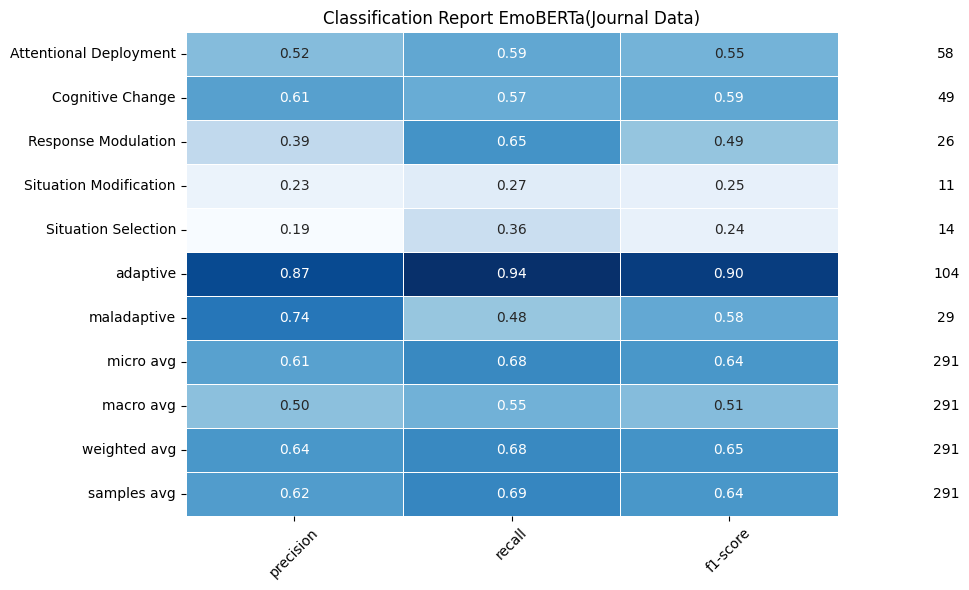

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report_dict = classification_report(true_labels, predictions, target_names=all_labels, output_dict=True)

# Convert to a DataFrame
df_report = pd.DataFrame(report_dict).T

# Separate the metrics and support
df_metrics = df_report.drop(columns=['support'])
df_support = df_report['support']

# Plot heatmap for metrics
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, cbar=False)

# Add support count as text annotations
for i, support in enumerate(df_support):
    plt.text(len(df_metrics.columns) + 0.5, i + 0.5, f"{int(support)}", ha='center', va='center')

plt.title("Classification Report EmoBERTa(Journal Data)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/classification_report_heatmap_emobertjour_7classes.png")
plt.show()